# Wasserstein Generative Adversarial Network

WGAN stands for Wasserstein Generative Adversarial Network. This variant of GAN improves the basic GAN architecture in a way to prevent issues related to training. Authors of the paper claim WGAN includes:
- A meaningful loss metric that correlates with the generator's convergence and sample quality
- Improved stability of the optimization process

Instead of using the binary crossentropy (defined as: $-\frac{1}{n}\sum_{i=1}^{n} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]$) with labels ($y_i$) corresponding to 1 (real images) et 0 (generated images) giving values in the interval $[0, 1]$, WGANs use the Wasserstein loss ($-\frac{1}{n}\sum_{i=1}^{n} \left[y_i p_i \right]$) which uses labels with values 1 (real images) or -1 (generated images) and returns values between $-\infty$ and $\infty$. For that reason the critic is now called a critic.  
The WGAN critic tries to maximise the difference between its predictions for real images and generetaed images, with real images scoring higher.

The Wasserstein loss potentially returns large values (which is generally to avoid in DNNs) and the WGAN can drastically change its critic for two images that are close. In order to counter that, the critic must be a 1-Lipschitz continuous function (ie: $\frac{\text{Absolute difference between critic predictions}}{\text{Average pixelwise absolute difference between images}} = \frac{|C(x_1) - C(x_2)|}{|x_1 - x_2|} \le 1$). That is to say, there must be a limit on the rate at which the predictions of the critic can change between two images. This is implemented using weight clipping (eventhough it impacts the critic's ability to learn, see WGAN-GP for a better solution).

Contrary to a GAN where the discriminator should not become to strong to avoid vanishing gradient, a WGAN needs the critic to be trained to convergence to ensure that the gradient for the generator are accurate. So it is possible to train the critic several times between generator updates, typically: 5 critic updates to 1 generator update.

Let's build an WGAN "from scratch" to have a better understanding!

## Hand Made Generative Adversarial Network

In [27]:
import os
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, UpSampling2D, Activation, BatchNormalization, Dropout, Conv2DTranspose
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop
from keras.callbacks import Callback, LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.utils import plot_model

# Clear TensorFlow session
K.clear_session()

# Disable eaager execution
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# Tensorflow debugging
# tf.debugging.enable_check_numerics()

import matplotlib.pyplot as plt

### critic

In [28]:
class Critic():

    def __init__(self,
                 input_dim, critic_n_layers, critic_conv_filters, critic_conv_kernel_sizes, critic_conv_strides,
                 critic_activation,
                 critic_batch_norm_momentum, critic_dropout_rate):
        self.input_dim = input_dim
        self.critic_n_layers = critic_n_layers
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_sizes = critic_conv_kernel_sizes
        self.critic_conv_strides = critic_conv_strides
        self.critic_activation = critic_activation
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_dropout_rate = critic_dropout_rate
        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.input = Input(shape=self.input_dim, name="critic_input")
        
        x = self.input
        for i in range(self.critic_n_layers):
            x = Conv2D(filters=self.critic_conv_filters[i],
                       kernel_size=self.critic_conv_kernel_sizes[i],
                       strides=self.critic_conv_kernel_sizes[i],
                       padding="same",
                       name="critic_conv_" + str(i))(x)
            
            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum=self.critic_batch_norm_momentum)(x)

            x = Activation(activation=self.critic_activation, name="critic_activation_" + str(i))(x)

            if self.critic_dropout_rate:
                x = Dropout(rate=self.critic_dropout_rate)(x)

        x = Flatten()(x)

        self.output = Dense(1, activation=None, kernel_initializer=self.weight_init, name="critic_output")(x)

        self.model = Model(self.input, self.output, name="critic")

    def summary(self):
        self.model.summary()

    def predict(self, x):
        return self.model.predict(x)

### Generator

In [29]:
class Generator():

    def __init__(self,
                 latent_dim, generator_initial_dense_layer_size, generator_n_layers, generator_upsamplings, generator_conv_filters, generator_conv_kernel_sizes, generator_conv_strides,
                 generator_activation,
                 generator_batch_norm_momentum, generator_dropout_rate):
        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_n_layers = generator_n_layers
        self.generator_upsamplings = generator_upsamplings
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_sizes = generator_conv_kernel_sizes
        self.generator_conv_strides = generator_conv_strides
        self.latent_dim = latent_dim
        self.generator_activation = generator_activation
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_dropout_rate = generator_dropout_rate

        self.input = Input(shape=(self.latent_dim,), name="generator_input")

        x = Dense(np.prod(self.generator_initial_dense_layer_size))(self.input) # Connect the input to a dense layer

        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum=self.generator_batch_norm_momentum)(x)

        x = Activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x) # Reshape latent space vector for convolutional transpose layers

        if self.generator_dropout_rate:
            x = Dropout(rate=self.generator_dropout_rate)(x)

        for i in range(self.generator_n_layers):
            if self.generator_upsamplings[i]:
                x = UpSampling2D(name="generator_up_sampling_" + str(i))(x)
                conv_layer = Conv2D(filters=self.generator_conv_filters[i],
                                    kernel_size=self.generator_conv_kernel_sizes[i],
                                    strides=self.generator_conv_strides[i],
                                    padding="same",
                                    name="generator_conv_" + str(i))
                x = conv_layer(x)
            else:
                conv_t_layer = Conv2DTranspose(filters=self.generator_conv_filters[i],
                                               kernel_size=self.generator_conv_kernel_sizes[i],
                                               strides=self.generator_conv_strides[i],
                                               padding="same",
                                               name="generator_conv_t_" + str(i))
                x = conv_t_layer(x)

            if i < self.generator_n_layers - 1:
                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum=self.generator_batch_norm_momentum)(x)
                x = Activation(activation="relu")(x)
            else:
                x = Activation(activation="tanh")(x)

        self.output = x

        self.model = Model(self.input, self.output, name="generator")

    def summary(self):
        self.model.summary()

    def predict(self, x):
        return self.model.predict(x)
        

### Generative Adversarial Network

In [30]:
class GenerativeAdversarialNetwork():

    def __init__(self,
                 input_dim, critic_n_layers, critic_conv_filters, critic_conv_kernel_sizes, critic_conv_strides,
                 critic_activation, critic_learning_rate,
                 critic_batch_norm_momentum, critic_dropout_rate,
                 latent_dim, generator_initial_dense_layer_size, generator_n_layers, generator_upsamplings, generator_conv_filters, generator_conv_kernel_sizes, generator_conv_strides,
                 generator_activation, generator_learning_rate,
                 generator_batch_norm_momentum, generator_dropout_rate):
        self.input_dim = input_dim
        self.critic_n_layers = critic_n_layers
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_sizes = critic_conv_kernel_sizes
        self.critic_conv_strides = critic_conv_strides
        self.critic_activation = critic_activation
        self.critic_learning_rate = critic_learning_rate
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_dropout_rate = critic_dropout_rate
        
        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_n_layers = generator_n_layers
        self.generator_upsamplings = generator_upsamplings
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_sizes = generator_conv_kernel_sizes
        self.generator_conv_strides = generator_conv_strides
        self.latent_dim = latent_dim
        self.generator_activation = generator_activation
        self.generator_learning_rate = generator_learning_rate
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_dropout_rate = generator_dropout_rate

        self.epoch = 0
        self.critic_losses = []
        self.generator_losses = []

        # Create critic
        self.critic = Critic(self.input_dim,
                                    self.critic_n_layers, self.critic_conv_filters, self.critic_conv_kernel_sizes, self.critic_conv_strides,
                                    self.critic_activation,
                                    self.critic_batch_norm_momentum, self.critic_dropout_rate)
        
        # Create Generator
        self.generator = Generator(self.latent_dim, self.generator_initial_dense_layer_size,
                                   self.generator_n_layers, self.generator_upsamplings, self.generator_conv_filters, self.generator_conv_kernel_sizes, self.generator_conv_strides,
                                   self.generator_activation,
                                   self.generator_batch_norm_momentum, self.generator_dropout_rate)

        def wasserstein_loss(y_true, y_pred):
            return -K.mean(y_true * y_pred)
        
        # Compile model that trains the critic
        self.critic.model.compile(optimizer=RMSprop(learning_rate=self.critic_learning_rate),
                                  loss=wasserstein_loss,
                                  metrics=["accuracy"])
        
        # Compile model that trains the generator
        self.set_trainable(self.critic.model, False)
        self.input = Input(shape=(self.latent_dim,), name="generated_adversarial_network_input")
        self.output = self.critic.model(self.generator.model(self.input))
        self.model = Model(self.input, self.output, name="generative_adversarial_network")
        self.model.compile(optimizer=RMSprop(learning_rate=self.generator_learning_rate),
                           loss=wasserstein_loss,
                           metrics=["accuracy"])
        self.set_trainable(self.critic.model, True)

    def summary(self):
        self.model.summary()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes=True, show_layer_names=True)
        plot_model(self.critic.model, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes=True, show_layer_names=True)
        plot_model(self.generator.model, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes=True, show_layer_names=True)

    def load_weights(self, filepath="model/weights/params.pkl"):
        self.model.load_weights(filepath)

    def set_trainable(self, model, value):
        model.trainable = value
        for l in model.layers:
            l.trainable = value

    def fit_critic(self, X_train, batch_size, clip_threshold):
        valid = np.ones((batch_size, 1))
        fake = -np.ones((batch_size, 1))

        # Train on real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        true_imgs = X_train[idx]
        d_loss_real, d_acc_real = self.critic.model.train_on_batch(true_imgs, valid)

        # Train on generated images
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        d_loss_gen, d_acc_gen = self.critic.model.train_on_batch(gen_imgs, fake)

        d_loss = 0.5 * (d_loss_real + d_loss_gen)
        d_acc = 0.5 * (d_acc_real + d_acc_gen)

        # Weight clipping to ensure 1-Lipschitz constraint
        for l in self.critic.model.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            l.set_weights(weights)

        return [d_loss, d_loss_real, d_loss_gen, d_acc, d_acc_real, d_acc_gen]
    
    def fit_generator(self, batch_size):
        valid = np.ones((batch_size, 1)) # Forces the generator to produce images considered as valid by the critic
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        return self.model.train_on_batch(noise, valid)
    
    def fit(self, X_train, batch_size, epochs, clip_threshold):

        for epoch in range(self.epoch, self.epoch + epochs):
            
            # Train the critic multiple times
            for _ in range(5):
                c = self.fit_critic(X_train, batch_size, clip_threshold)

            # Train the generator once
            g = self.fit_generator(batch_size)

            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, c[0], c[1], c[2], c[3], c[4], c[5], g[0], g[1]))

            self.critic_losses.append(c)
            self.generator_losses.append(g)

            self.epoch += 1

    def predict(self, x):
        return self.model.predict(x)

    def save(self, folder="model"):
        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'weights/params.pkl'), 'wb') as f:
            pickle.dump([self.input_dim,
                         self.critic_conv_filters,
                         self.critic_conv_kernel_sizes,
                         self.critic_conv_strides,
                         self.critic_batch_norm_momentum,
                         self.critic_dropout_rate,
                         self.latent_dim,
                         self.generator_conv_filters,
                         self.generator_conv_kernel_sizes,
                         self.generator_conv_strides,
                         self.generator_batch_norm_momentum,
                         self.generator_dropout_rate], f)
        self.plot_model(folder)

In [31]:
LATENT_DIM = 100

generative_adversarial_network = GenerativeAdversarialNetwork(input_dim=(28,28,1),
                                                              critic_n_layers=4,
                                                              critic_conv_filters=[64,64,128,128],
                                                              critic_conv_kernel_sizes=[5,5,5,5],
                                                              critic_conv_strides=[2,2,2,1],
                                                              critic_activation='relu',
                                                              critic_learning_rate=0.0008,
                                                              critic_batch_norm_momentum=None,
                                                              critic_dropout_rate=0.4,
                                                              latent_dim=LATENT_DIM,
                                                              generator_initial_dense_layer_size=(7,7,64),
                                                              generator_n_layers=4,
                                                              generator_upsamplings=[True,False,True,False],
                                                              generator_conv_filters=[128,64,64,1],
                                                              generator_conv_kernel_sizes=[5,5,5,5],
                                                              generator_conv_strides=[1,1,1,1],
                                                              generator_activation='relu',
                                                              generator_learning_rate=0.0004,
                                                              generator_batch_norm_momentum=0.9,
                                                              generator_dropout_rate=None)

In [32]:
generative_adversarial_network.plot_model("model")

In [33]:
generative_adversarial_network.critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 critic_conv_0 (Conv2D)      (None, 6, 6, 64)          1664      
                                                                 
 critic_activation_0 (Activ  (None, 6, 6, 64)          0         
 ation)                                                          
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 critic_conv_1 (Conv2D)      (None, 2, 2, 64)          102464    
                                                                 
 critic_activation_1 (Activ  (None, 2, 2, 64)          0         
 ation)                                                     

In [34]:
generative_adversarial_network.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLaye  [(None, 100)]             0         
 r)                                                              
                                                                 
 dense (Dense)               (None, 3136)              316736    
                                                                 
 batch_normalization (Batch  (None, 3136)              12544     
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 generator_up_sampling_0 (U  (None, 14, 14, 64)        0 

In [35]:
generative_adversarial_network.summary()

Model: "generative_adversarial_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GAN_input (InputLayer)      [(None, 100)]             0         
                                                                 
 generator (Functional)      (None, 28, 28, 1)         844161    
                                                                 
 critic (Functional)         (None, 1)                 718913    
                                                                 
Total params: 1563074 (5.96 MB)
Trainable params: 1556290 (5.94 MB)
Non-trainable params: 6784 (26.50 KB)
_________________________________________________________________


### Load Data

In [36]:
# Load MNIST dataset
mnist_dataset = mnist.load_data()
(trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
(X_train, y_train) = trainset
(X_test, y_test) = testset

# Preprocess data (convert to float and scale to between 0 and 1)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.astype('float32')
X_test /= 255

# Preprocess data (convert to uint8)
# y_train = y_train.astype('uint8')
# y_test = y_test.astype('uint8')

### Train

In [37]:
BATCH_SIZE = 64
EPOCHS = 2000
CLIP_THRESHOLD = 0.01

In [38]:
generative_adversarial_network.fit(X_train, BATCH_SIZE, EPOCHS, CLIP_THRESHOLD)

2/2 [==============================] - 0s 88ms/step
0 [D loss: (0.001)(R -0.001, F 0.002)] [D acc: (0.000)(0.000, 0.000)] [G loss: -0.001] [G acc: 0.000]
2/2 [==============================] - 0s 82ms/step
1 [D loss: (0.000)(R -0.001, F 0.002)] [D acc: (0.000)(0.000, 0.000)] [G loss: -0.001] [G acc: 0.000]
2/2 [==============================] - 0s 82ms/step
2 [D loss: (0.000)(R -0.001, F 0.002)] [D acc: (0.000)(0.000, 0.000)] [G loss: -0.001] [G acc: 0.000]
2/2 [==============================] - 0s 74ms/step
3 [D loss: (0.000)(R -0.001, F 0.002)] [D acc: (0.000)(0.000, 0.000)] [G loss: -0.001] [G acc: 0.000]
2/2 [==============================] - 0s 89ms/step
4 [D loss: (0.000)(R -0.001, F 0.002)] [D acc: (0.000)(0.000, 0.000)] [G loss: -0.001] [G acc: 0.000]
2/2 [==============================] - 0s 102ms/step
5 [D loss: (0.000)(R -0.001, F 0.002)] [D acc: (0.000)(0.000, 0.000)] [G loss: -0.001] [G acc: 0.000]
2/2 [==============================] - 0s 81ms/step
6 [D loss: (0.000)(R -0

KeyboardInterrupt: 

### Evaluate Generative Adversarial Network

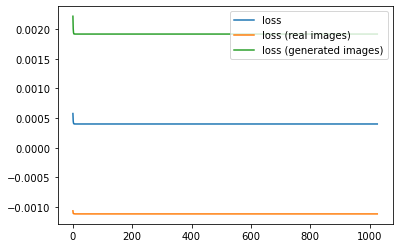

In [39]:
# Plot critic losses
plt.plot([row[0] for row in generative_adversarial_network.critic_losses], label="loss")
plt.plot([row[1] for row in generative_adversarial_network.critic_losses], label="loss (real images)")
plt.plot([row[2] for row in generative_adversarial_network.critic_losses], label="loss (generated images)")
plt.legend()
plt.show()

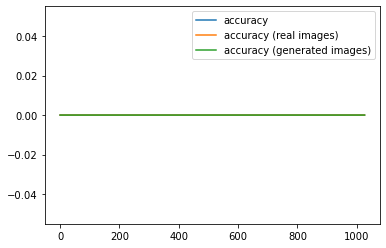

In [40]:
# Plot critic accuracy
plt.plot([row[3] for row in generative_adversarial_network.critic_losses], label="accuracy")
plt.plot([row[4] for row in generative_adversarial_network.critic_losses], label="accuracy (real images)")
plt.plot([row[5] for row in generative_adversarial_network.critic_losses], label="accuracy (generated images)")
plt.legend()
plt.show()

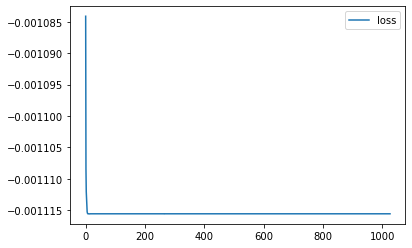

In [41]:
# Plot generator loss
plt.plot([row[0] for row in generative_adversarial_network.generator_losses], label="loss")
plt.legend()
plt.show()

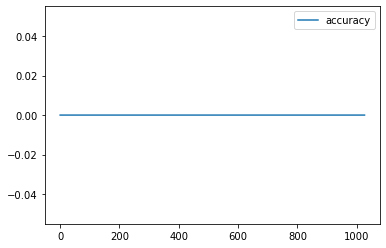

In [42]:
# Plot generator accuracy
plt.plot([row[1] for row in generative_adversarial_network.generator_losses], label="accuracy")
plt.legend()
plt.show()

### Save Model

In [43]:
generative_adversarial_network.save()

### Load Pre-Trained Model

In [44]:
# variational_autoencoder.load_weights()

### Predictions

In [45]:
def modifier_vector(size, dim, value):
    v = np.zeros(shape=(1,size))
    v[dim] = value
    return v

In [46]:
NB_PRED = 5

latent_vector_init = np.random.random(size=(1,LATENT_DIM))

latent_vectors = tf.data.Dataset.from_tensor_slices([latent_vector_init + modifier_vector(LATENT_DIM, 0, i) for i in range(NB_PRED)])

# list(latent_vectors.as_numpy_iterator())

In [47]:
latent_vectors

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 100), dtype=tf.float64, name=None)>

In [48]:
def l1_compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

def find_closest(img):
    closest = None
    closest_l1 = None
    for i in X_train:
        l1 = l1_compare_images(img, i)
        if closest_l1 is None or l1 < closest_l1:
            closest = i
            closest_l1 = l1
    for i in X_test:
        l1 = l1_compare_images(img, i)
        if closest_l1 is None or l1 < closest_l1:
            closest = i
            closest_l1 = l1
    return closest, closest_l1

5/5 [==============================] - 0s 9ms/step


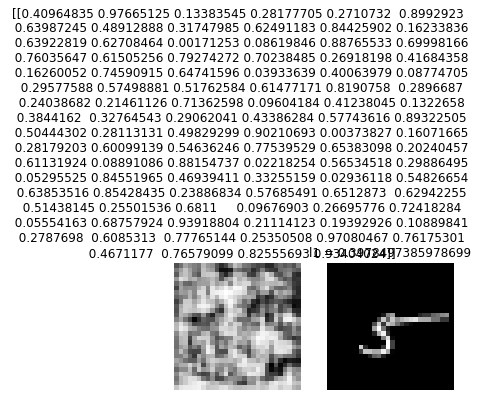

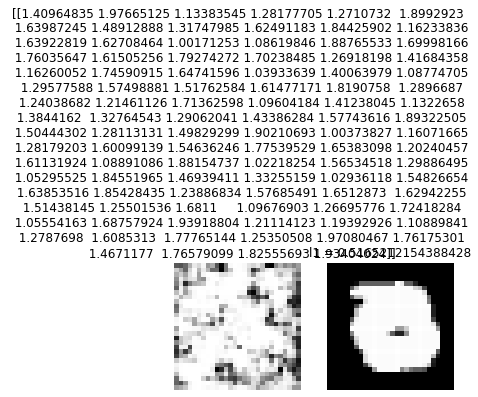

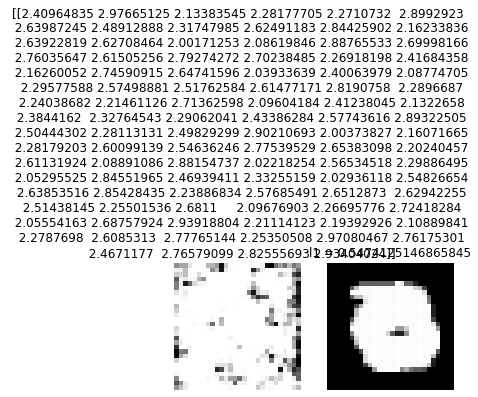

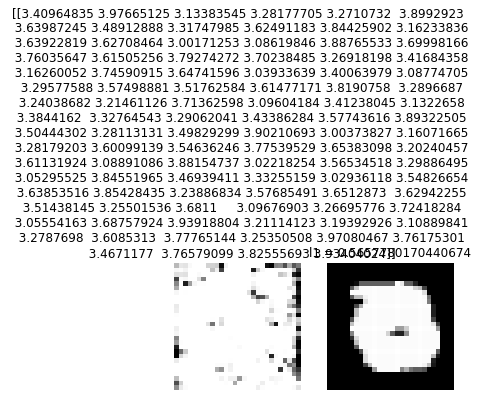

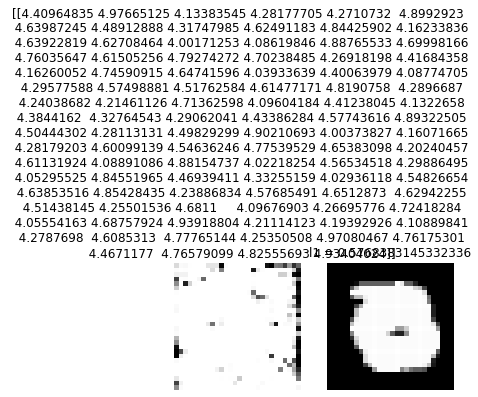

In [49]:
predictions = generative_adversarial_network.generator.predict(latent_vectors)

closest_in_dataset = []
latent_vectors_iterator = iter(latent_vectors)
for i in range(NB_PRED):
    closest_in_dataset.append(find_closest(predictions[i]))
    plt.figure(figsize=((5,5)))
    plt.subplot(1,2,1)
    plt.imshow(predictions[i], cmap="gray")
    plt.title(f"{latent_vectors_iterator.get_next()}")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(closest_in_dataset[i][0], cmap="gray")
    plt.title(f"l1 = {closest_in_dataset[i][1]}")
    plt.axis("off")